In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
#from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
vars = ["p_mean", "pet_mean", "aridity", "snow_frac", "high_prec_freq", "high_prec_dur",  "low_prec_freq", "low_prec_dur"]
vars = vars + ["elev_mean","slope_mean","prcFlatTotal","prcFlatLowland","prcFlatUpland","relief","cidx"]
vars = vars + ["forest_frac","cropland_frac","urban_frac","gvf_max","gvf_diff","lai_max","lai_diff"] 
vars = vars + ["sand_frac", "clay_frac", "soil_porosity", "soil_conductivity", "soil_depth"]       
vars = vars + ["geol_porostiy", "geol_permeability"]
vars0 = ["q_mean","runoff_ratio","slope_fdc","baseflow_index", "hfd_mean", "q5","q95","high_q_freq","high_q_dur","low_q_freq","low_q_dur", "zero_q_freq"]      
vars1 = ["prcFlatTotal","prcFlatLowland","prcFlatUpland","relief","cidx","cropland_frac","urban_frac"]
vars2 = ["aridity","forest_frac","sand_frac", "clay_frac", "soil_depth"]

## Load datasets

In [3]:
# domain meta data
meta = pd.read_csv("../data/nwmv2.1/Domain_Meta_Final_Calib_V2.1_2018_9_30.csv")

# calibrated parameters
pars = pd.read_csv("../data/nwmv2.1/Calib_Stats_Best.txt",sep=' ')
pars = pars.merge(meta,on="domainID")
#pars = pars.loc[pars['rfc'].isin(['NWRFC'])]
#pars = pars.loc[pars['snowy']==1]

# TODO: deal with parameter multipliers
# defaul parameter values in ../data/nwmv2.1/par_def_camles_basins.Rdata

# attributes
attrs = pd.read_csv("../data/nwmv2.1/attrs_all.txt",dtype={'gauge_id':'str'})
print(attrs.columns)

# certain attributes
#attrs = attrs.loc[:,["gauge_id"] + vars + vars0 + vars2 + vars1]
#attrs = attrs.loc[:,["gauge_id"] + vars2 + vars1]

Index(['gauge_id', 'prcFlatTotal', 'prcFlatLowland', 'prcFlatUpland', 'relief',
       'cidx', 'cropland_frac', 'urban_frac', 'aridity', 'forest_frac',
       'sand_frac', 'clay_frac', 'soil_depth', 'p_mean', 'pet_mean',
       'snow_frac', 'high_prec_freq', 'high_prec_dur', 'low_prec_freq',
       'low_prec_dur', 'elev_mean', 'slope_mean', 'gvf_max', 'gvf_diff',
       'lai_max', 'lai_diff', 'soil_porosity', 'soil_conductivity',
       'geol_porostiy', 'geol_permeability', 'q_mean', 'runoff_ratio',
       'slope_fdc', 'baseflow_index', 'hfd_mean', 'q5', 'q95', 'high_q_freq',
       'high_q_dur', 'low_q_freq', 'low_q_dur', 'zero_q_freq'],
      dtype='object')


## Loop through parameters to plot feature importance

The R2 score on test set for bexp: 0.3187


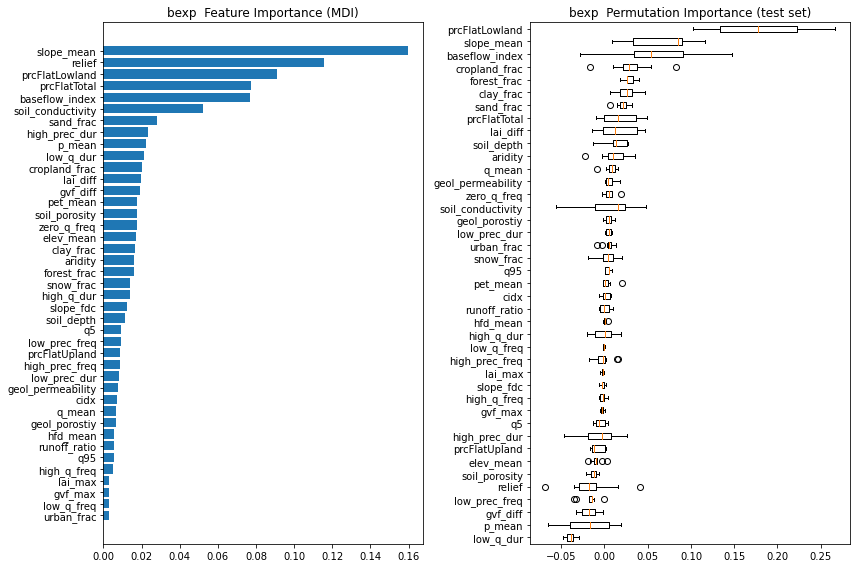

In [4]:
par_names = [x for x in pars.columns[:16] if x not in ['domainID','jobID',"ID"]]
for par1 in par_names[:1]:
    
    # assemble input and target data
    dtAttrs = attrs.merge(pars.loc[:,['ID',par1]],left_on='gauge_id',right_on='ID')

    # assemble input data
    X = dtAttrs.copy()
    X.drop(['gauge_id','ID',par1],axis=1,inplace=True)
    attr_names = X.columns
    X = X.to_numpy(copy=True)

    # target data
    y = dtAttrs[par1].to_numpy(copy=True)
    # data preprocessing
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=13
    )

    params = {
        "n_estimators": 500,
        "max_depth": 4,
        "min_samples_split": 5,
        "learning_rate": 0.01,
    #    "loss": "squared_loss", #this parameter needs a newer version scikit-learn than 0.24.1
    }
    
    # fit regression model
    reg = ensemble.GradientBoostingRegressor(**params)
    reg.fit(X_train, y_train)

    mse = r2_score(y_test, reg.predict(X_test))
    print("The R2 score on test set for " +par1 +": {:.4f}".format(mse))
    
    # plot feature importance
    feature_importance = reg.feature_importances_
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + 0.5
    fig = plt.figure(figsize=(12, 8))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feature_importance[sorted_idx], align="center")
    plt.yticks(pos, np.array(attr_names)[sorted_idx])
    plt.title(par1 + "  Feature Importance (MDI)")

    result = permutation_importance(
        reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
    )
    sorted_idx = result.importances_mean.argsort()
    plt.subplot(1, 2, 2)
    plt.boxplot(
        result.importances[sorted_idx].T,
        vert=False,
        labels=np.array(attr_names)[sorted_idx],
    )
    plt.title(par1 + "  Permutation Importance (test set)")
    fig.tight_layout()
    plt.show()